<img src='stats/img/topbar.png' />

## Deep Learning for Computer Vision

__CONTEÚDO:__<br>
* [1. Convnets](#1.)
* [1.1 Aplicação 1: The Dogs vs. Cats dataset - Convnets + Data Augmentation](#1.1)
* [1.2 Aplicação 2: The Dogs vs. Cats dataset - Convnets + Transfer Learning + Fine Tuning](#1.2)

<a id="1."></a><br>
### 1. Convnets

                     (Baseado no livro Deep Learning with Python, de François Chollet - 2018)
- A diferença fundamental entre camadas *densely connected* e *convolution* é que a primeira aprende padrões globais no espaço de características enquanto a segunda aprende padrões locais das diversas regiões que compõe o espaço.
- Os padrões percebidos são invariantes às diferenças de posição translacionais.
- A rede aprende os padrões de forma hierarquizada entre as camadas.

<img src='stats/img/cat_eg.png' width=400 />

<a id="1.1"></a><br>
### 1.1 Aplicação 1: The Dogs vs. Cats dataset - Convnets + Data Augmentation <br>

__ETAPAS:__<br><br>
[1. Definir o problema e montar o dataset](#1.1.1) <br>
[2. Escolher uma métrica de sucesso](#1.1.2) <br>
[3. Definir um protocolo de avaliação](#1.1.3) <br>
[4. Adequar os dados para a rede](#1.1.4) <br>
[5. Desenvolver um modelo base](#1.1.5) <br>
[6. Desenvolver um modelo com overfitting](#1.1.6) <br>
[7. Regularizar e sintonizar hiperparâmetros do modelo](#1.1.7) <br>

<a id="1.1.1"></a><br>
**1. Definir o problema e montar o dataset**

- Nessa aplicação, o objetivo é classificar as imagens de entrada se contém um cachorro ou um gato.
- O dataset completo para treino possui 12500 imagens por classe.
- O dataset completo para teste possui 6250 imagens por classe.
- Para manter a ideia de usar um conjunto pequeno, serão selecionadas de forma aleatória 2000 imagens por classe do _dataset_ completo.

In [3]:
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
# from keras.models import load_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Número de instâncias por classe
full_set_size = 1500
train_size = 1000
validation_size = 500

In [3]:
np.random.seed(101)

full_index = list(range(0, 12500))
random.shuffle(full_index)
full_index = full_index[:1500]

In [4]:
train_index = full_index[:1000]
validation_index = full_index[1000:]

In [5]:
test_size = 500
test_index = random.sample(range(0, 6250), test_size)

In [6]:
train_dir = 'data\\dogs-vs-cats_dataset\\train-set\\'
train_dir

'data\\dogs-vs-cats_dataset\\train-set\\'

In [7]:
test_dir = 'data\\dogs-vs-cats_dataset\\test-set\\'
test_dir

'data\\dogs-vs-cats_dataset\\test-set\\'

In [8]:
fnames = [['cat.{}.jpg'.format(i), 'cat'] for i in train_index]
fnames.extend([['dog.{}.jpg'.format(i), 'dog'] for i in train_index])

df_train = pd.DataFrame(fnames, columns=['rel_img_path', 'animal'])
df_train

,rel_img_path,animal
0,cat.12199.jpg,cat
1,cat.6761.jpg,cat
2,cat.9139.jpg,cat
3,cat.11349.jpg,cat
4,cat.3956.jpg,cat
...,...,...
1995,dog.3425.jpg,dog
1996,dog.1952.jpg,dog
1997,dog.11183.jpg,dog
1998,dog.2784.jpg,dog


In [9]:
fnames = [['cat.{}.jpg'.format(i), 'cat'] for i in validation_index]
fnames.extend([['dog.{}.jpg'.format(i), 'dog'] for i in validation_index])

df_valid = pd.DataFrame(fnames, columns=['rel_img_path', 'animal'])
df_valid

,rel_img_path,animal
0,cat.11015.jpg,cat
1,cat.5385.jpg,cat
2,cat.6091.jpg,cat
3,cat.12040.jpg,cat
4,cat.7848.jpg,cat
...,...,...
995,dog.10308.jpg,dog
996,dog.9720.jpg,dog
997,dog.1766.jpg,dog
998,dog.1501.jpg,dog


In [10]:
fnames = ['{}.jpg'.format(i) for i in test_index]
df_test = pd.DataFrame(fnames, columns=['rel_img_path'])
df_test

,rel_img_path
0,3595.jpg
1,1955.jpg
2,4551.jpg
3,2530.jpg
4,214.jpg
...,...
495,3241.jpg
496,4594.jpg
497,5364.jpg
498,942.jpg


<a id="1.1.2"></a><br>
**2. Escolher uma métrica de sucesso**

- Como essa aplicação é de classificação binária, a métrica será a acurácia em classificar imagens como contendo cachorro ou gato. Pelo histórico de aplicações desse dataset, é possível alcançar cerca de **95%** de acurácia, então esse valor será usado como referência.

<a id="1.1.3"></a><br>
**3. Definir um protocolo de avaliação**

- O conjunto de imagens separadas para a aplicação será dividido em conjuntos de treino, teste e validação. Serão usadas: 2000 imagens de treinamento (1000 por classe), 1000 imagens para validação (500 por classe) e 1000 imagens para teste.

<a id="1.1.4"></a><br>
**4. Adequar os dados para a rede**

In [11]:
# Os dados devem ser formatados para tensores 'floating-point', pois originalmente são imagens
# A classe ImageDataGenerator permite preparar generators a partir de arquivos, formando lotes de tensores preprocessados
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
#train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=20, class_mode='binary')
train_generator = train_datagen.flow_from_dataframe(df_train, train_dir, x_col='rel_img_path', y_col='animal',  
                                                    target_size=(150, 150), batch_size=20, 
                                                    class_mode='binary')

Found 2000 validated image filenames belonging to 2 classes.


In [13]:
valid_generator = validation_datagen.flow_from_dataframe(df_valid, train_dir, x_col='rel_img_path', y_col='animal',  
                                                    target_size=(150, 150), batch_size=20, 
                                                    class_mode='binary')

Found 1000 validated image filenames belonging to 2 classes.


<a id="1.1.5"></a><br>
**5. Desenvolver um modelo base**

In [14]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
# Configuração do modelo para treinamento
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

In [16]:
# Treinamento com generator que carregam as entradas embutidas
history = model.fit(train_generator, steps_per_epoch=100, epochs=30, 
                    validation_data=valid_generator, validation_steps=50)

Epoch 1/30
100/100 [==============================] - 32s 325ms/step - loss: 0.6921 - acc: 0.5180 - val_loss: 0.6801 - val_acc: 0.5540
Epoch 2/30
100/100 [==============================] - 29s 289ms/step - loss: 0.6668 - acc: 0.5995 - val_loss: 0.6547 - val_acc: 0.6180
Epoch 3/30
100/100 [==============================] - 29s 290ms/step - loss: 0.6425 - acc: 0.6315 - val_loss: 0.6574 - val_acc: 0.5980
Epoch 4/30
100/100 [==============================] - 29s 291ms/step - loss: 0.6099 - acc: 0.6645 - val_loss: 0.6841 - val_acc: 0.5650
Epoch 5/30
100/100 [==============================] - 29s 293ms/step - loss: 0.5790 - acc: 0.7030 - val_loss: 0.5926 - val_acc: 0.6950
Epoch 6/30
100/100 [==============================] - 29s 292ms/step - loss: 0.5545 - acc: 0.7055 - val_loss: 0.5901 - val_acc: 0.6850
Epoch 7/30
100/100 [==============================] - 29s 293ms/step - loss: 0.5317 - acc: 0.7330 - val_loss: 0.5969 - val_acc: 0.6740
Epoch 8/30
100/100 [==============================] - 3

In [17]:
# É uma boa prática salvar o modelo após criado e treinado
# Em outras seções do notebook, se não houver mudanças em partes anteriores, basta carregar o modelo e iniciar daí
model.save('saved_models/DeepLearningForComputerVision/cats_and_dogs_small_1.h5')

In [ ]:
# model = load_model('saved_models/DeepLearningForComputerVision/cats_and_dogs_small_1.h5')

In [1]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

NameError: name 'history' is not defined

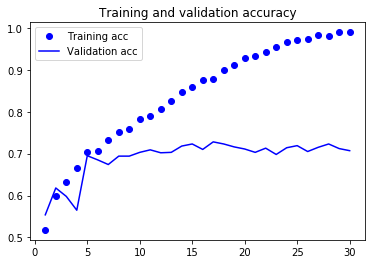

In [19]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

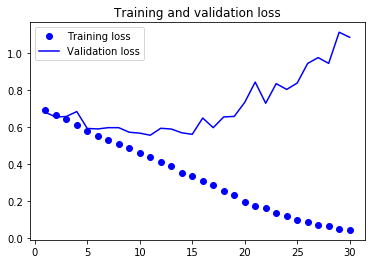

In [20]:
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

<a id="1.1.6"></a><br>
**6. Desenvolver um modelo com overfitting**

In [23]:
# Será considerado que o modelo já possui uma arquitetura adequada
# Nos gráficos é possível observar que ocorre overfitting

<a id="1.1.7"></a><br>
**7. Regularizar ou sintonizar hiperparâmetros do modelo**

- Em modelos convnets voltados à processamento de imagens/visão computacional, é comum ser usado a técnica de _data augmentation,_ que consiste em reutilizar as imagens do treinamento com algumas transformações aleatórias, o que será percebido pelo modelo (quase) como uma imagem diferente.
- Essa técnica permite permite o modelo capturar outros aspectos das imagens e assim obter um poder maior de generalização.
- Além de _data augmentation,_ será usada uma camada de _dropout_ para facilitar no desafio de evitar _overfitting_

In [21]:
# Novo modelo
final_model = models.Sequential()

final_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
final_model.add(layers.MaxPooling2D((2, 2)))

final_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
final_model.add(layers.MaxPooling2D((2, 2)))

final_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
final_model.add(layers.MaxPooling2D((2, 2)))

final_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
final_model.add(layers.MaxPooling2D((2, 2)))

final_model.add(layers.Flatten())
final_model.add(layers.Dropout(0.5))

final_model.add(layers.Dense(512, activation='relu'))
final_model.add(layers.Dense(1, activation='sigmoid'))

In [22]:
final_model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

In [28]:
# ImageDataGenerator para realizar data augmentation
train_datagen = ImageDataGenerator( rescale=1./255,
                                    rotation_range=40, # random range to rotate
                                    width_shift_range=0.2, height_shift_range=0.2, # random range to translate
                                    shear_range=0.2, # random range to shear
                                    zoom_range=0.2, # random zoom range
                                    horizontal_flip=True)

In [29]:
# O data augmentation não é aplicado no conjunto de validação (final), test_gen

In [30]:
train_generator = train_datagen.flow_from_dataframe(df_train, train_dir, x_col='rel_img_path', y_col='animal',  
                                                    target_size=(150, 150), batch_size=20, 
                                                    class_mode='binary')

Found 2000 validated image filenames belonging to 2 classes.


In [31]:
valid_generator = validation_datagen.flow_from_dataframe(df_valid, train_dir, x_col='rel_img_path', y_col='animal',  
                                                         target_size=(150, 150), batch_size=20, class_mode='binary')

Found 1000 validated image filenames belonging to 2 classes.


In [32]:
# Treinamento com generator que carregam as entradas embutidas (com data augmentation)
history = final_model.fit(train_generator, steps_per_epoch=100, epochs=100, validation_data=valid_generator, validation_steps=50)

Epoch 1/100
100/100 [==============================] - 28s 283ms/step - loss: 0.6924 - acc: 0.5215 - val_loss: 0.6796 - val_acc: 0.6010
Epoch 2/100
100/100 [==============================] - 29s 288ms/step - loss: 0.6886 - acc: 0.5380 - val_loss: 0.6687 - val_acc: 0.6170
Epoch 3/100
100/100 [==============================] - 31s 311ms/step - loss: 0.6753 - acc: 0.5775 - val_loss: 0.6568 - val_acc: 0.5930
Epoch 4/100
100/100 [==============================] - 30s 298ms/step - loss: 0.6691 - acc: 0.5855 - val_loss: 0.6438 - val_acc: 0.6170
Epoch 5/100
100/100 [==============================] - 31s 305ms/step - loss: 0.6600 - acc: 0.5965 - val_loss: 0.7038 - val_acc: 0.5730
Epoch 6/100
100/100 [==============================] - 31s 310ms/step - loss: 0.6484 - acc: 0.6215 - val_loss: 0.6986 - val_acc: 0.5660
Epoch 7/100
100/100 [==============================] - 30s 305ms/step - loss: 0.6404 - acc: 0.6280 - val_loss: 0.6143 - val_acc: 0.6630
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 29s 289ms/step - loss: 0.4614 - acc: 0.7895 - val_loss: 0.6185 - val_acc: 0.7180
Epoch 62/100
100/100 [==============================] - 29s 290ms/step - loss: 0.4491 - acc: 0.7810 - val_loss: 0.5244 - val_acc: 0.7590
Epoch 63/100
100/100 [==============================] - 29s 289ms/step - loss: 0.4659 - acc: 0.7770 - val_loss: 0.6052 - val_acc: 0.7240
Epoch 64/100
100/100 [==============================] - 29s 290ms/step - loss: 0.4622 - acc: 0.7730 - val_loss: 0.5114 - val_acc: 0.7660
Epoch 65/100
100/100 [==============================] - 29s 289ms/step - loss: 0.4659 - acc: 0.7725 - val_loss: 0.4769 - val_acc: 0.7750
Epoch 66/100
100/100 [==============================] - 29s 290ms/step - loss: 0.4574 - acc: 0.7865 - val_loss: 0.5168 - val_acc: 0.7660
Epoch 67/100
100/100 [==============================] - 29s 289ms/step - loss: 0.4654 - acc: 0.7785 - val_loss: 0.4816 - val_acc: 0.7760
Epoch 68/100
100/100 [===================

In [33]:
final_model.save('saved_models/DeepLearningForComputerVision/cats_and_dogs_small_2.h5')

In [8]:
final_model = models.load_model('saved_models/DeepLearningForComputerVision/cats_and_dogs_small_2.h5')

In [ ]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'saved_models/DeepLearningForComputerVision/cats_and_dogs_small_2_history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
# hist_csv_file = 'history.csv'
# with open(hist_csv_file, mode='w') as f:
#    hist_df.to_csv(f)

# hist_df = pd.read_json('saved_models/DeepLearningForComputerVision/cats_and_dogs_small_2_history.json')

In [7]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

NameError: name 'history' is not defined

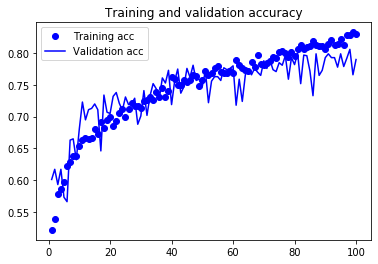

In [35]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

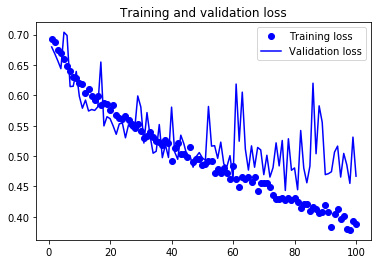

In [36]:
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

- Aplicando somente a técnica _Data Augmentation_ foi possível reduzir o overfitting mas não atingiu a meta de 95%.
- Outras técnicas são apresentadas na seção 1.2.

<a id="1.2"></a><br>
### 1.2 Aplicação 2: The Dogs vs. Cats dataset - Convnet + Transfer Learning
<br>

__ETAPAS:__<br><br>
[1. Definir o problema e montar o dataset](#1.2.1) <br>
[2. Escolher uma métrica de sucesso](#1.2.2) <br>
[3. Definir um protocolo de avaliação](#1.2.3) <br>
[4. Adequar os dados para a rede](#1.2.4) <br>
[5. Desenvolver um modelo base](#1.2.5) <br>
[6. Desenvolver um modelo com overfitting](#1.2.6) <br>
[7. Regularizar e sintonizar hiperparâmetros do modelo](#1.2.7) <br>

- Convnets treinadas com massiva quantidade de dados e com um escopo mais genérico podem servir a problemas menos genéricos com alguns ajustes, ainda que envolvam classes diferentes da aplicação original, podendo inclusive alcançar desempenhos melhores.
- A técnica de reutilizar um modelo pré-treinado em um outro problema é conhecida como __*Transfer Learning*__.
- Nesse caso, será utilizado uma Convnet treinada no ImageNet dataset, conjunto bem conhecido em aplicações de Machine Learning. Ela possui 1,4 milhões de imagens classificadas e 1000 classes diferentes, onde também inclui muitas classes de animais com diferentes raças de cachorros e gatos.
- Duas técnicas para o reuso são *__feature extraction__* e *__fine-tuning__*. Ambas podem ser aplicadas no mesmo modelo em desenvolvimento.
- Feature extraction consiste em usar representações aprendidas por uma outra rede para extrair features na sua aplicação, ou seja, com suas próprias amostras. Então, a partir dessas features extraídas, desenvolver um mecanismo de classificação para identificar as classes.

<a id="1.2.1"></a><br>
**1. Definir o problema e montar o dataset**

- O dataset **_Dogs vs Cats_** será classificado usando a arquitetura VGG16, desenvolvida por Karen Simonyan e Andrew Zisserman em 2014.

In [2]:
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
# from keras.models import load_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
%matplotlib inline

Using TensorFlow backend.


In [3]:
# Carregamento de Convnet pré-treinada
conv_base = VGG16( weights='imagenet', 
                   include_top=False, # Manter camada de entrada da rede? Não, será adicionada uma específica para o caso
                   input_shape=(150, 150, 3))

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [15]:
base_dir = 'data\\dogs-vs-cats_dataset\\'

<a id="1.2.2"></a><br>
**2. Escolher uma métrica de sucesso**

- Como essa aplicação é de classificação binária, a métrica será a acurácia em classificar imagens como contendo cachorro ou gato. Pelo histórico de aplicações desse dataset, é possível alcançar cerca de **95%** de acurácia, então esse valor será usado como referência. <Também será observado a curva de ROC.>


<a id="1.2.3"></a><br>
**3. Definir um protocolo de avaliação**

- O conjunto de imagens separadas para a aplicação será dividido em conjuntos de treino, teste e validação. Serão escolhidas aleatoriamente: 2000 imagens de treinamento (1000 por classe), 1000 imagens para validação (500 por classe) e 1000 imagens para teste.

In [18]:
# Referências para seleção de instâncias por classe
full_set_size = 1500
train_size = 1000
validation_size = 500
np.random.seed(101)

In [19]:
full_index = list(range(0, 12500))
random.shuffle(full_index)

full_index = full_index[:full_set_size]
train_index = full_index[:train_size]
validation_index = full_index[train_size:]

In [20]:
test_size = 500
test_index = random.sample(range(0, 12500), test_size)

<a id="1.1.4"></a><br>
**4. Adequar os dados para a rede - Versão A: Fast Feature Extraction sem Data Augmentation**

In [13]:
import os, shutil

# Organizar estrutura de pastas para o conjunto de treino

def prepare_dir(dir):
    
    try:
        os.mkdir(dir)
    except FileExistsError as fe:
        pass
    except Exception as e:
        print(dir, e)


def prepare_dir_structure(base_dir):    
    
    samples_dir = os.path.join(base_dir, 'samples')
    train_dir = os.path.join(samples_dir, 'train')
    validation_dir = os.path.join(samples_dir, 'validation')
    train_cats_dir = os.path.join(train_dir, 'cats')
    train_dogs_dir = os.path.join(train_dir, 'dogs')
    validation_cats_dir = os.path.join(validation_dir, 'cats')
    validation_dogs_dir = os.path.join(validation_dir, 'dogs')
    test_dir = os.path.join(samples_dir, 'test')
    
    prepare_dir(samples_dir)
    prepare_dir(train_dir)
    prepare_dir(validation_dir)
    prepare_dir(train_cats_dir)
    prepare_dir(train_dogs_dir)
    prepare_dir(validation_cats_dir)
    prepare_dir(validation_dogs_dir)
    prepare_dir(test_dir)
    prepare_dir(os.path.join(test_dir, 'unlabeled-data'))

    return train_dir, validation_dir, test_dir

In [11]:
# Separar imagens para treino com validação e testes, ambas usando as referências aleatórias geradas anteriormente
# As amostras são copiadas pra a pasta de operação de forma a complementar a quantidade pré-existente.
# O ideal é substituir tudo, mas tá sendo feito assim para reduzir o número de operações de cópia no disco
def prepare_samples(dataset_dir, dest_dir, random_ref):
    
    dst = os.path.join(dest_dir, 'cats')
    n_cats = len([name for name in os.listdir(dst) if os.path.isfile(os.path.join(dst, name))])
    
    counter = 0
    max_img = len(random_ref)
    print('Max. img cats: {}; current n_cats: {}'.format(max_img, n_cats))
    for i in random_ref:
        if counter + n_cats < max_img:
            fname = 'cat.{}.jpg'.format(i)
            src = os.path.join(dataset_dir, fname)
            # dst = os.path.join(dest_dir, 'cats')
            # dst = os.path.join(dst, fname)
            shutil.copyfile(src, os.path.join(dst, fname))
            counter = counter + 1
        else:
            counter = 0
            break
    
    dst = os.path.join(dest_dir, 'dogs')
    n_dogs = len([name for name in os.listdir(dst) if os.path.isfile(os.path.join(dst, name))])
    
    print('Max. img dogs: {}; current n_dogs: {}'.format(max_img, n_dogs))
    for i in random_ref:
        if counter + n_dogs < max_img:
            fname = 'dog.{}.jpg'.format(i)
            src = os.path.join(dataset_dir, fname)
            # dst = os.path.join(dest_dir, 'dogs')
            # dst = os.path.join(dst, fname)
            shutil.copyfile(src, os.path.join(dst, fname))
            counter = counter + 1
        else:
            counter = 0
            break

def prepare_test_samples(dataset_dir, dest_dir, random_ref):
    dest_dir = os.path.join(dest_dir, 'unlabeled-data')
    counter = 0
    n_ref = len(random_ref)
    n_samples = len([name for name in os.listdir(dest_dir) if os.path.isfile(os.path.join(dest_dir, name))])
    
    for i in random_ref:
        if counter + n_samples < n_ref:
            fname = '{}.jpg'.format(i)
            src = os.path.join(dataset_dir, fname)
            dst = os.path.join(dest_dir, fname)
            shutil.copyfile(src, dst)

In [9]:
batch_size = 20
datagen = ImageDataGenerator(rescale=1./255)

# Extração de características das imagens através da rede pré-treinada VGG16
def extract_features(directory, class_mode='binary'):
    
    if (class_mode != None):
        
        dogs_dir = os.path.join(directory, 'dogs')
        cats_dir = os.path.join(directory, 'cats')
        n_dogs = len([name for name in os.listdir(dogs_dir) if os.path.isfile(os.path.join(dogs_dir, name))])    
        n_cats = len([name for name in os.listdir(cats_dir) if os.path.isfile(os.path.join(cats_dir, name))])    
    
        n_samples = n_dogs + n_cats
        
        features = np.zeros(shape=(n_samples, 4, 4, 512))      # Associado a dimensão do topo da rede pré-treinada
        
        labels = np.zeros(shape=(n_samples))

        generator = datagen.flow_from_directory(directory, target_size=(150, 150), batch_size=20, class_mode=class_mode)

        i = 0
        for inputs_batch, labels_batch in generator:
            features_batch = conv_base.predict(inputs_batch)
            features[i * batch_size : (i + 1) * batch_size] = features_batch
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch
            i += 1
            if i * batch_size >= n_samples:
                break

        return features, labels
    
    else:
        
        source_dir = os.path.join(directory, 'unlabeled-data')
        
        n_samples = len([name for name in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, name))])
        
        features = np.zeros(shape=(n_samples, 4, 4, 512))      # Associado a dimensão do topo da rede pré-treinada

        generator = datagen.flow_from_directory(directory, target_size=(150, 150), batch_size=20, class_mode=None)
        i = 0
        for inputs_batch in generator:
            features_batch = conv_base.predict(inputs_batch)
            features[i * batch_size : (i + 1) * batch_size] = features_batch
            i += 1
            if i * batch_size >= n_samples:
                break

        return features

In [16]:
train_dir, validation_dir, test_dir = prepare_dir_structure(base_dir)
print(train_dir)
print(validation_dir)
print(test_dir)

data\dogs-vs-cats_dataset\samples\train
data\dogs-vs-cats_dataset\samples\validation
data\dogs-vs-cats_dataset\samples\test


In [21]:
dataset_dir = os.path.join(base_dir, 'train-set')
prepare_samples(dataset_dir, train_dir, train_index)
prepare_samples(dataset_dir, validation_dir, validation_index)

Max. img cats: 1000; current n_cats: 1000
Max. img dogs: 1000; current n_dogs: 1000
Max. img cats: 500; current n_cats: 500
Max. img dogs: 500; current n_dogs: 500


In [22]:
train_features, train_labels = extract_features(train_dir)

Found 2000 images belonging to 2 classes.


In [23]:
validation_features, validation_labels = extract_features(validation_dir)

Found 1000 images belonging to 2 classes.


In [24]:
dataset_dir = os.path.join(base_dir, 'test-set')
prepare_test_samples(dataset_dir, test_dir, test_index)

In [25]:
test_features = extract_features(test_dir, class_mode=None)

Found 500 images belonging to 1 classes.


In [81]:
train_features = np.reshape(train_features, (2 * train_size, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (2 * validation_size, 4 * 4 * 512))
test_features = np.reshape(test_features, (test_size, 4 * 4 * 512))

In [82]:
# Preparação de classificador densely connected para realizar a tarefa de classificação pelas features extraídas
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

In [83]:
history = model.fit(train_features, train_labels, epochs=30, batch_size=20, 
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 2s 18ms/step - loss: 0.5891 - acc: 0.6725 - val_loss: 0.4287 - val_acc: 0.8440
Epoch 2/30
100/100 [==============================] - 2s 16ms/step - loss: 0.4114 - acc: 0.8115 - val_loss: 0.3548 - val_acc: 0.8500
Epoch 3/30
100/100 [==============================] - 2s 16ms/step - loss: 0.3399 - acc: 0.8630 - val_loss: 0.3245 - val_acc: 0.8670
Epoch 4/30
100/100 [==============================] - 2s 16ms/step - loss: 0.3080 - acc: 0.8665 - val_loss: 0.3089 - val_acc: 0.8700
Epoch 5/30
100/100 [==============================] - 2s 16ms/step - loss: 0.2675 - acc: 0.8940 - val_loss: 0.3074 - val_acc: 0.8630
Epoch 6/30
100/100 [==============================] - 2s 16ms/step - loss: 0.2584 - acc: 0.8990 - val_loss: 0.2910 - val_acc: 0.8760
Epoch 7/30
100/100 [==============================] - 2s 16ms/step - loss: 0.2377 - acc: 0.9070 - val_loss: 0.2921 - val_acc: 0.8720
Epoch 8/30
100/100 [==============================] - 2s 16ms/step - 

In [84]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

<Figure size 432x288 with 0 Axes>

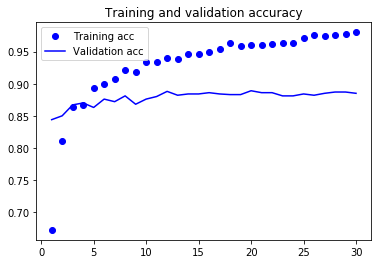

<Figure size 432x288 with 0 Axes>

In [85]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

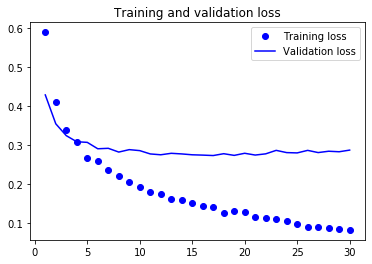

In [86]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### 5. Test on Unseen Data

In [87]:
# REALIZAR A PREDIÇÃO COM O MODEL USANDO O CONJUNTO DE TESTE NÃO ETIQUETADO E VERIFICAR A ESTATISTICA DO TESTE

#### 6. Feature Extraction + Data Augmentation

In [89]:
# definição do modelo para aplicação das técnicas de Feature Extraction e Data Augmentation combinadas ao modelo VGG16
model_fe = models.Sequential()
model_fe.add(conv_base)
model_fe.add(layers.Flatten())
model_fe.add(layers.Dense(256, activation='relu'))
model_fe.add(layers.Dense(1, activation='sigmoid'))

In [91]:
model_fe.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [100]:
"""A rede VGG16 está sendo travada para evitar atualizações que possam ocorrer durante o treinamento. 
Assim, somente a camada adicionada ao topo passará por aprendizado"""

print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 4
This is the number of trainable weights after freezing the conv base: 4


In [27]:
train_datagen = ImageDataGenerator( rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

In [28]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [29]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

Found 2000 images belonging to 2 classes.


In [30]:
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

Found 1000 images belonging to 2 classes.


In [110]:
model_fe.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

In [115]:
# (Processo Demorado)
history = model_fe.fit(x=train_generator, steps_per_epoch=100, epochs=30,
                    validation_data=validation_generator, validation_steps=30) # next: test validation_steps=50

Epoch 1/30
100/100 [==============================] - 82s 815ms/step - loss: 0.3890 - acc: 0.8365 - val_loss: 0.3108 - val_acc: 0.8700
Epoch 2/30
100/100 [==============================] - 82s 824ms/step - loss: 0.3823 - acc: 0.8295 - val_loss: 0.3232 - val_acc: 0.8700
Epoch 3/30
100/100 [==============================] - 83s 831ms/step - loss: 0.3557 - acc: 0.8500 - val_loss: 0.3249 - val_acc: 0.8633
Epoch 4/30
100/100 [==============================] - 83s 828ms/step - loss: 0.3476 - acc: 0.8410 - val_loss: 0.3103 - val_acc: 0.8600
Epoch 5/30
100/100 [==============================] - 83s 832ms/step - loss: 0.3419 - acc: 0.8500 - val_loss: 0.2840 - val_acc: 0.8783
Epoch 6/30
100/100 [==============================] - 84s 836ms/step - loss: 0.3319 - acc: 0.8605 - val_loss: 0.2939 - val_acc: 0.8717
Epoch 7/30
100/100 [==============================] - 84s 839ms/step - loss: 0.3214 - acc: 0.8590 - val_loss: 0.2996 - val_acc: 0.8733
Epoch 8/30
100/100 [==============================] - 8

In [116]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

<Figure size 432x288 with 0 Axes>

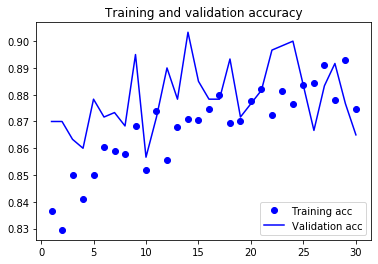

<Figure size 432x288 with 0 Axes>

In [119]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

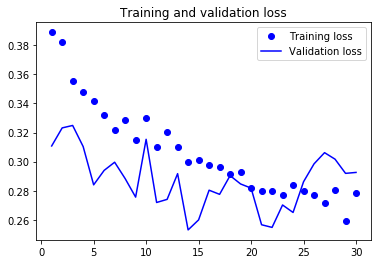

In [120]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### 6. Fine Tuning

In [123]:
# Estrutura da rede VGG16
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

<img src='stats/img/vgg16_fine_tuning.png' />

**Passos para realizar o Fine-Tuning**
- 1. Add your custom network on top of an already-trained base network.
- 2. Freeze the base network.
- 3. Train the part you added.
- 4. Unfreeze some layers in the base network.
- 5. Jointly train both these layers and the part you added.

OBS: com a técnica de *Feature Extraction* da seção anterior, já foram cumpridos os passos de 1 a 3.

In [4]:
# Desbloqueio para que as camadas 5 em diante possam passar por mais treinamentos
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [5]:
model_full = models.Sequential()
model_full.add(conv_base)
model_full.add(layers.Flatten())
model_full.add(layers.Dense(256, activation='relu'))
model_full.add(layers.Dense(1, activation='sigmoid'))

In [6]:
model_full.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])

In [31]:
history = model_full.fit(x=train_generator, steps_per_epoch=100, epochs=30,
                    validation_data=validation_generator, validation_steps=50)

Epoch 1/30
100/100 [==============================] - 114s 1s/step - loss: 0.5465 - acc: 0.7315 - val_loss: 0.3588 - val_acc: 0.8510
Epoch 2/30
100/100 [==============================] - 116s 1s/step - loss: 0.3780 - acc: 0.8325 - val_loss: 0.2899 - val_acc: 0.8860
Epoch 3/30
100/100 [==============================] - 115s 1s/step - loss: 0.3220 - acc: 0.8630 - val_loss: 0.2615 - val_acc: 0.8890
Epoch 4/30
100/100 [==============================] - 117s 1s/step - loss: 0.2829 - acc: 0.8800 - val_loss: 0.2365 - val_acc: 0.9050
Epoch 5/30
100/100 [==============================] - 115s 1s/step - loss: 0.2724 - acc: 0.8835 - val_loss: 0.2285 - val_acc: 0.9090
Epoch 6/30
100/100 [==============================] - 115s 1s/step - loss: 0.2384 - acc: 0.9030 - val_loss: 0.2247 - val_acc: 0.9000
Epoch 7/30
100/100 [==============================] - 118s 1s/step - loss: 0.2355 - acc: 0.8990 - val_loss: 0.2021 - val_acc: 0.9180
Epoch 8/30
100/100 [==============================] - 118s 1s/step - 

In [41]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

<Figure size 432x288 with 0 Axes>

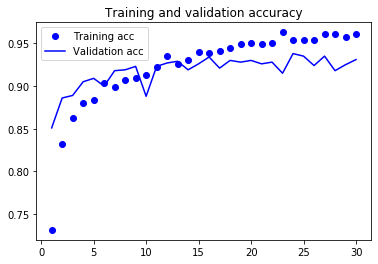

<Figure size 432x288 with 0 Axes>

In [42]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

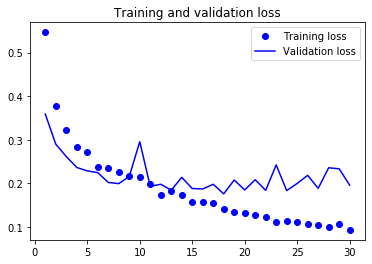

In [34]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

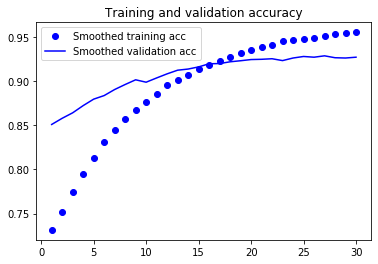

<Figure size 432x288 with 0 Axes>

In [46]:
# Suavização das curvas - para melhor avaliar tendência nas curvas de accuracy e loss
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

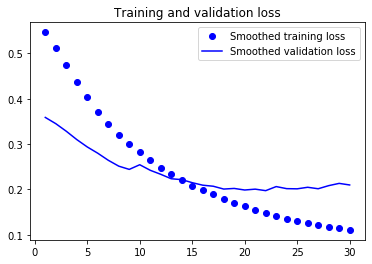

In [47]:
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()